In [29]:
import sys 
sys.path.append("/mnt/raid-cita/dtolgay/FIRE/post_processing_fire_outputs")
from tools import functions as doga_funcs
from tools import functions_readfiles as doga_readfiles
from tools import constants
from tools import functions_importing_observations as import_observations

import pandas as pd 
import numpy as np 

import funcs as gunjan_funcs

import matplotlib.pyplot as plt
plt.style.use("seaborn-poster")

# Gunjan's Functions 

In [2]:
M_sun      = 1.99e33   # in gms 
kpc        = 3.08e21   # in cms 
pc         = kpc/1.e3
k_b        = 1.380e-16 # in erg K^(-1)
m_proton   = 1.672e-24 # in gms 
gamma      = 5./3      # adiabatic index 
omega_m    = 0.272
omega_b    = 0.0455
omega_c    = omega_m - omega_b
sigma_dust = 5.e-22    # cm^(2) g^(-1)]] 
h          = 0.7       # Hubble_parameter
solar_metallicity = 0.02 #solar mass fraction

def gunjan_return_h2_fraction(gas_density, smoothing_gas, Z_prime, clumping_factor):
    local_column_density            =  gas_density*smoothing_gas*1.e10/1.e6
    tau_c                           = clumping_factor*local_column_density*2.e3*M_sun/(pc**2.)*Z_prime
    chi                             = 3.1*(1.+3.1*Z_prime**0.365)/4.1
    s                               = np.log(1.+0.6*chi+0.01*chi**2)/(0.6*tau_c)
    h2_fraction                     = 1. - (3.*s)/(4.*(1.+ 0.25*s))
    h2_fraction[h2_fraction < 0. ]  = 0.

    return h2_fraction, tau_c, local_column_density


def gunjan_corrected_h2_fraction(gas_density, smoothing_gas, Z_prime, clumping_factor):
    
    local_column_density            =  gas_density*smoothing_gas*1.e10/1.e6 # Molar/pc2
    
    # Corrected tau_c 
    sigma_d = Z_prime * 1e-21
    mu_h = 2.3e-24

    tau_c = clumping_factor * (local_column_density * M_sun / pc**2 ) * sigma_d / mu_h
    
    
    
    chi                             = 3.1*(1.+3.1*Z_prime**0.365)/4.1
    s                               = np.log(1.+0.6*chi+0.01*chi**2)/(0.6*tau_c)
    h2_fraction                     = 1. - (3.*s)/(4.*(1.+ 0.25*s))
    h2_fraction[h2_fraction < 0. ]  = 0.    
    
    return h2_fraction, tau_c, local_column_density


# Doga Functions 

In [3]:

def doga_h2_mass_fraction_calculator(
    local_density_scale_height, 
    density, 
    metallicity, 
    clumping_factor
):

    print("I am in the function h2_mass_fraction_calculator") 


    """This function is used to calculate the H2 mass fraction by using the formula 1 in the paper:
    A Comparison of Methods for Determining the Molecular Content of Model Galaxies by Krumholz, and Gnedin (2011)

    Arguments:
    ----------
    local_density_scale_height: array_like
        In this equation smooting length of the gas is assumed to be accurate estimation of the local density scale height. 
        Therefore smooting length is used instead of local density scale height
        [pc]

    density: array_like
        Density of the gas particles
        [gr / cm^3]

    metallicity: array_like
        metallicity of the gas particles 
        [Zsolar]

    clumping_factor: double or int or array-like
        It is a parameter to boost the h2 mass fraction and therefore h2 column density and CO luminosity
        [unitless]

    Returns:
    ----------
    h2_mass_fraction: array_like
        h2_mass_fraction = h2_gas_mass / total_gas_mass
        [unitless]

    column_density: array_like
        It is the column density considering all elements in the gas particle
        [gr/cm^2]

    dust_optical_depth: array_like  
        tau_c in the reference paper. It was being output in order to control the code
        [unitless]

    References: 
    -----------
    A Comparison of Methods for Determining the Molecular Content of Model Galaxies by Krumholz, and Gnedin (2011)

    """ 


    # The units of local_density_scale_height is kpc 
    local_density_scale_height = local_density_scale_height * constants.pc2cm  # [cm]

    # Calculation of column density 
    column_density = density * local_density_scale_height   # [gr / cm^2]
    # Column density is the summation sign in the paper
    # Gunjan assumed that local density scale height is same with the smoooting length of the gas particles. I will continue on this assumption
    # but I don't know how it works

    # Calculation of dust cross section (sigma_d in txhe paper)
    dust_cross_section_per_H_nucleus_normalized_to_1eminus21 = metallicity
    dust_cross_section = dust_cross_section_per_H_nucleus_normalized_to_1eminus21 * 1e-21   # [cm^2]


    # Calculation of dust optical depth (tau_c in the paper)
    # mu_h is the mean mass per H nucleus
    mu_h = 2.3e-24  # [gr] 
    # clumping factor is used to increase the H2 formation to account for density inhomogeneities that are unresolved on the computational grid
    # since the H2 formation rate varies as the square of density, these inhomogeneities increase the overall rate
    dust_optical_depth = clumping_factor * column_density * dust_cross_section / mu_h     # [dimensionless]   

    # Calculation for scaled radiation field (chi in the paper) Eq 4 
    # This scaled radiation field will not likely to hold cell-by-cell every time step, but it should hold on average
    # clumping factor is used to boost the formation rate of the H2 molecules on dust grains (the R term)   
    scaled_radiation_field = 3.1 * (1 + 3.1 * metallicity**0.365) / 4.1  # [dimensionless]

    # Calculation for s in the paper (Eq 2)
    s = np.log(1 + 0.6*scaled_radiation_field + 0.01 * scaled_radiation_field**2 ) / ( 0.6 * dust_optical_depth )
    
    # If s > 2 then fh2 < 0 which is unphysical. So set s greter than 2 to 2. 
#     s[s>2] = 2

    # Calculation for the H2 mass fraction (f_H2 in the paper Eq 1)
    h2_mass_fraction = 1 - (3/4) * (s / (1 + 0.25*s))   # [dimensionless]
    
    h2_mass_fraction[h2_mass_fraction < 0] = 0

    return h2_mass_fraction, dust_optical_depth, column_density 



# Import gas particles 

In [4]:
galaxy_name = "m12i_res7100_md"
redshift = "3.0"
directory_name = "voronoi_1e6"
galaxy_type = "zoom_in"

doga_gas = doga_readfiles.read_cloudy_gas_particles(
        galaxy_name, 
        galaxy_type, 
        redshift, 
        directory_name,
        base_fdir = f"/mnt/raid-cita/dtolgay/FIRE/post_processing_fire_outputs/skirt/runs_hden_radius"
    )



In [5]:
# Change the units for the gunjan's particles 
gunjan_gas = doga_gas.copy()


# Position pc -> kpc
gunjan_gas[['x', 'y', 'z']] /= 1e3 #kpc

# Length pc -> kpc 
gunjan_gas[['smoothing_length', 'average_sobolev_smoothingLength', 'radius']] /= 1e3 #kpc

# mass Msolar -> 1e10 Msolar 
gunjan_gas['mass'] /= 1e10

# density gr/cm3 -> 1e10Msolar/kpc3
gunjan_gas['density'] = gunjan_gas['density'] * constants.gr2Msolar / 1e10 / (constants.cm2kpc)**3

# metallicity Zsolar 

# velocity km/s  

# Drop unused columns
gunjan_gas.drop(['hden', 'turbulence', 'mu_theoretical', 'isrf'], axis=1, inplace=True)


# Create another array to store Gunjan's corrected code outputs 
gunjan_corrected_gas = gunjan_gas.copy()

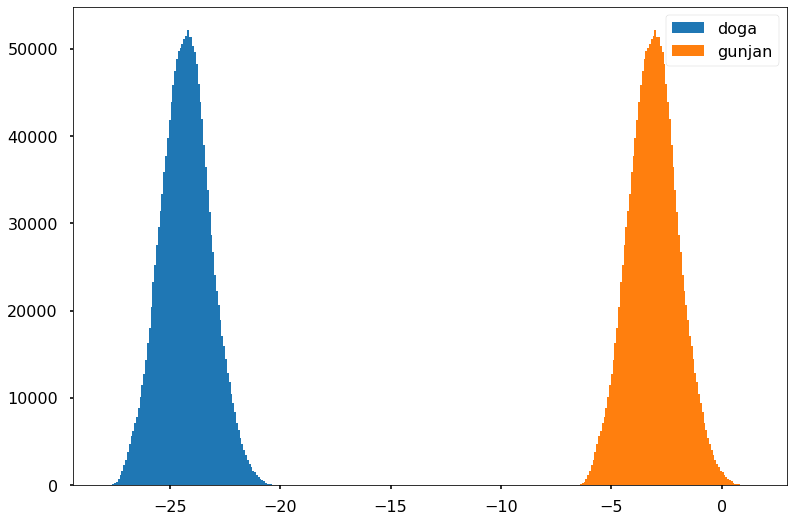

In [6]:
# Check histogram plots 

prop = "density"

plt.hist(np.log10(doga_gas[prop]), bins=100, label="doga")
plt.hist(np.log10(gunjan_gas[prop]), bins=100, label="gunjan")

plt.legend()
plt.show()

# Calculating fh2

## Gunjan

In [7]:
gunjan_gas['fh2'], gunjan_gas['tau_c'], gunjan_gas['column_density'] = gunjan_return_h2_fraction(
    gas_density = gunjan_gas['density'].to_numpy(), 
    smoothing_gas = gunjan_gas['smoothing_length'].to_numpy(),
    Z_prime = gunjan_gas['metallicity'].to_numpy(), 
    clumping_factor = 1
)

gunjan_corrected_gas['fh2'], gunjan_corrected_gas['tau_c'], gunjan_corrected_gas['column_density'] = gunjan_corrected_h2_fraction(
    gas_density = gunjan_corrected_gas['density'].to_numpy(), 
    smoothing_gas = gunjan_corrected_gas['smoothing_length'].to_numpy(),
    Z_prime = gunjan_corrected_gas['metallicity'].to_numpy(), 
    clumping_factor = 1    
)

## Doga

In [8]:
doga_gas['fh2'], doga_gas['tau_c'], doga_gas['column_density'] = doga_h2_mass_fraction_calculator(
    local_density_scale_height = doga_gas['smoothing_length'].to_numpy(), 
    density = doga_gas['density'].to_numpy(), 
    metallicity = doga_gas['metallicity'].to_numpy(), 
    clumping_factor = 1
)

I am in the function h2_mass_fraction_calculator


### Histogram plots

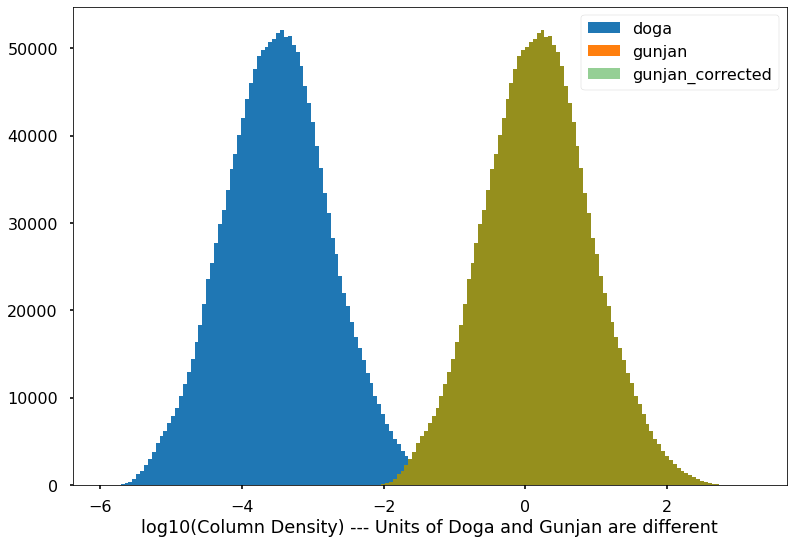

In [17]:
# Check histogram plots 

prop = "column_density"


plt.hist(np.log10(doga_gas[prop]), bins=100, label="doga")
plt.hist(np.log10(gunjan_gas[prop]), bins=100, label="gunjan")
plt.hist(np.log10(gunjan_corrected_gas[prop]), bins=100, label="gunjan_corrected", alpha=0.5)


plt.legend()

plt.xlabel("log10(Column Density) --- Units of Doga and Gunjan are different")
plt.show()

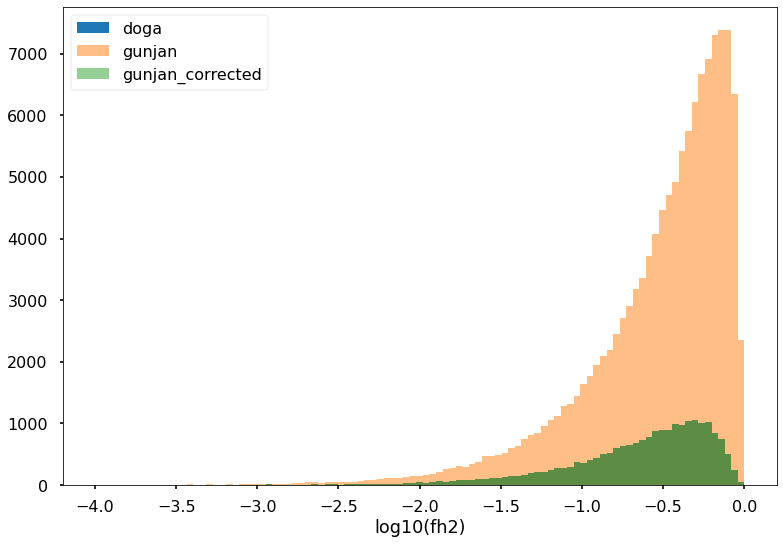

In [20]:
prop = "fh2"
bins = np.linspace(-4, 0, num=100)
plt.hist(np.log10(doga_gas[prop]), bins=bins, label="doga")
plt.hist(np.log10(gunjan_gas[prop]), bins=bins, label="gunjan", alpha=0.5)
plt.hist(np.log10(gunjan_corrected_gas[prop]), bins=bins, label="gunjan_corrected", alpha=0.5)

plt.legend()

plt.xlabel("log10(fh2)")
plt.show()

My results and Gunjan's corrected results are just on top of each other

# Total Molecular Gas Mass

In [28]:
# Doga 
doga_Mh2_tot = sum(doga_gas['fh2'] * doga_gas['mass']) # Msolar 

# Gunjan 
gunjan_Mh2_tot = sum(gunjan_gas['fh2'] * gunjan_gas['mass'] * 1e10) # Msolar

# Gunjan corrected 
gunjan_corrected_Mh2_tot = sum(gunjan_corrected_gas['fh2'] * gunjan_corrected_gas['mass'] * 1e10) # Msolar


print(f"doga: {doga_Mh2_tot/1e7} E7 -- \ngunjan: {gunjan_Mh2_tot/1e7} E7 -- \ngunjan_corrected: {gunjan_corrected_Mh2_tot/1e7} E7")

doga: 5.189179373662086 E7 -- 
gunjan: 37.79587205511042 E7 -- 
gunjan_corrected: 5.1891793736620855 E7


# Comparing with Observations

In [30]:
XCOLDGASS_df, PHIBBS2_df, ALMA_df, Leroy_df = import_observations.read_CO_observations()

I am in the function XCold_Gass_data_reading
I am in the function PHIBSS2_data_reading
I am in the function ALMA_2019_Data_Reading
I am in the function Leroy_data_reading
average_radius_r25_times_075_LEROY:  8.886206896551723


In [31]:
XCOLDGASS_df.keys()

Index(['Id', 'Lco', 'Xco', 'Mh2', 'SFR', 'metallicity', 'FLAG_CO', 'Mstar'], dtype='object')

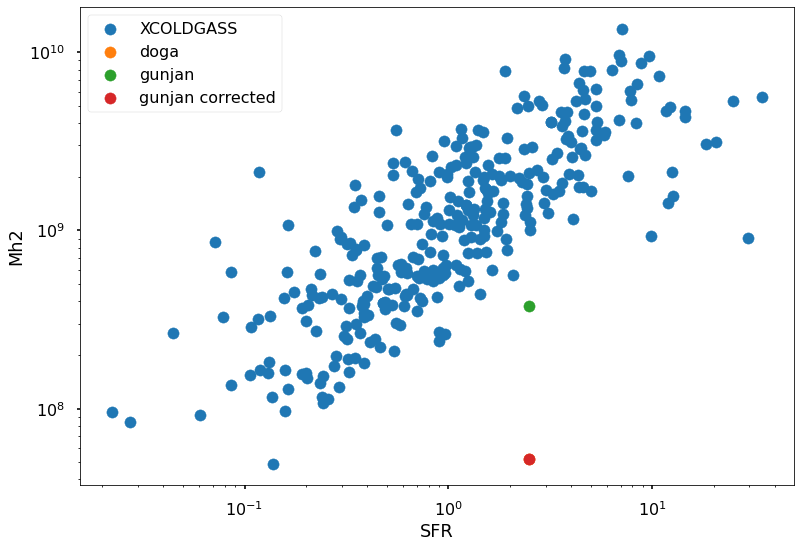

In [40]:
detections = XCOLDGASS_df['FLAG_CO'] == 1

plt.scatter(XCOLDGASS_df.loc[detections, 'SFR'], XCOLDGASS_df.loc[detections, 'Mh2'], label="XCOLDGASS")

total_sfr = sum(doga_gas['sfr'])
plt.scatter(total_sfr, doga_Mh2_tot, label="doga")
plt.scatter(total_sfr, gunjan_Mh2_tot, label="gunjan")
plt.scatter(total_sfr, gunjan_corrected_Mh2_tot, label="gunjan corrected")

plt.xscale("log")
plt.yscale("log")
plt.legend()

plt.xlabel("SFR")
plt.ylabel("Mh2")
plt.show()